## **Aplicação de Decision Tree Regression**
Neste notebook será aplicado o modelo Decision Tree Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/features_train_df.csv", parse_dates=['ds'], index_col=[0])
test_df = pd.read_csv("data/features_test_df.csv", parse_dates=['ds'], index_col=[0])

In [3]:
import json

with open("data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

## **Decision Tree Regression**

In [4]:
from src.features import add_trend


def dt_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = test_df.query(
        "unique_id == @train.unique_id[0]").reset_index(drop=True)
    train, fcst_df = add_trend(train, fcst_df)
    features = selected_features[train.unique_id[0]]

    m = DecisionTreeRegressor()
    m.fit(X=train[features], y=train.y)

    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [5]:
# aplicando modelo para cada série
dt_fcst = train_df.groupby("unique_id") \
    .apply(dt_regressor) \
    .reset_index(drop=True)

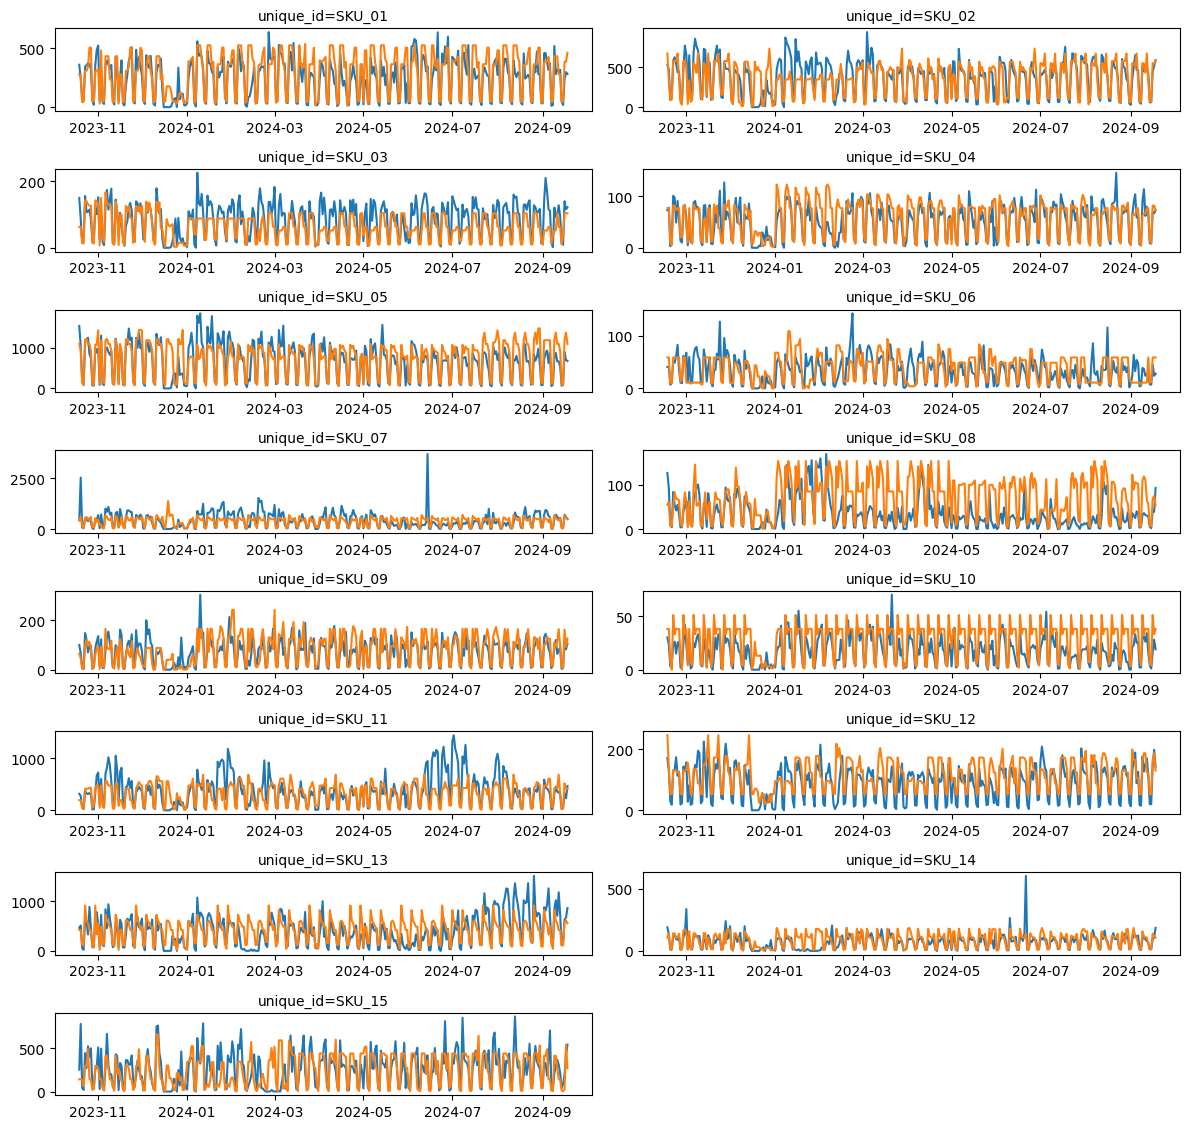

In [6]:
fig = plot_time_series(df=dt_fcst, data_cols=['y', 'y_pred'])

In [7]:
rf_eval = Evaluation(dt_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Decision Tree')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,87.10,14809.65,121.69,0.47
SKU_02,107.33,24272.73,155.80,0.53
SKU_03,31.24,1812.51,42.57,0.36
SKU_04,16.10,522.29,22.85,0.53
SKU_05,215.55,97481.92,312.22,0.51
SKU_06,18.48,645.72,25.41,-0.03
SKU_07,211.65,116641.26,341.53,0.28
SKU_08,41.31,3003.57,54.80,-1.33
SKU_09,30.88,1902.43,43.62,0.29
SKU_10,12.38,253.32,15.92,-0.57


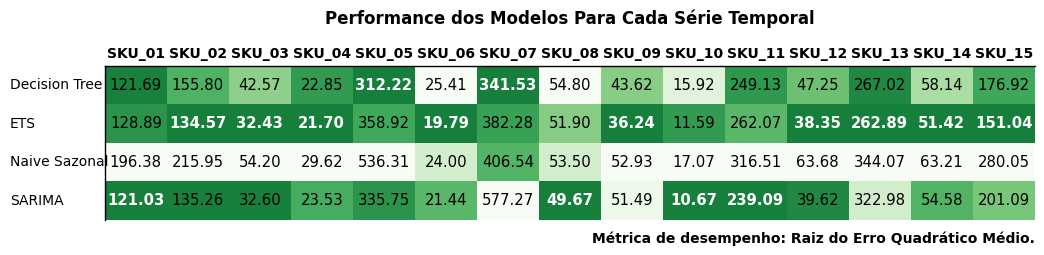

In [8]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].sort_values().unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 2))